In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO, autoguide, Predictive
from pyro.optim import Adam, ClippedAdam
import torch
import pyro
from torch.distributions import constraints
from pyro.contrib.gp.models.model import GPModel as gpr

In [2]:
df = pd.read_csv('./data/df_hourly_january.csv', parse_dates=['datetime'])
df.set_index(['datetime', 'cell_id'], inplace=True)

In [3]:
df

,,acc_count,X,Y
datetime,cell_id,,,
2023-01-01 00:00:00,"(717514.445, 6177963.565)",0,NaN,NaN
2023-01-01 01:00:00,"(717514.445, 6177963.565)",0,NaN,NaN
2023-01-01 02:00:00,"(717514.445, 6177963.565)",0,NaN,NaN
2023-01-01 03:00:00,"(717514.445, 6177963.565)",0,NaN,NaN
2023-01-01 04:00:00,"(717514.445, 6177963.565)",0,NaN,NaN
...,...,...,...,...
2023-01-31 19:00:00,"(729014.445, 6173963.565)",0,NaN,NaN
2023-01-31 20:00:00,"(729014.445, 6173963.565)",0,NaN,NaN
2023-01-31 21:00:00,"(729014.445, 6173963.565)",0,NaN,NaN


In [4]:
# --- Toy subset: first calendar month ------------------------------------------------
df_day = df.copy()

# Convert UTM (metres) to kilometres for nicer kernel length‑scale priors
coords = df_day[["X", "Y"]].dropna().values / 1_000.0  # shape (n_points, 2)

# Re‑centre so the south‑west corner is (0,0)
coords = coords - coords.min(0, keepdims=True)

In [5]:
cell_size = 0.5  # km – feel free to shrink if memory explodes

nx = int(np.ceil(coords[:, 0].max() / cell_size)) + 1
ny = int(np.ceil(coords[:, 1].max() / cell_size)) + 1
n_cells = nx * ny
print(f"Grid: {nx} × {ny}  ⇒  {n_cells} cells\n")

# Map each accident into its grid cell id
cell_x = (coords[:, 0] / cell_size).astype(int)
cell_y = (coords[:, 1] / cell_size).astype(int)
cell_ids = cell_x + nx * cell_y

counts = np.bincount(cell_ids, minlength=n_cells)  # accidents per cell
counts = torch.tensor(counts, dtype=torch.float32)

# Pre‑compute grid‑cell centroids (in km)
grid_x, grid_y = np.meshgrid(np.arange(nx), np.arange(ny))
centroids = np.stack([grid_x.ravel(), grid_y.ravel()], 1) * cell_size  # (n_cells, 2)
centroids = torch.tensor(centroids, dtype=torch.float32)

Grid: 23 × 24  ⇒  552 cells



In [ ]:
def rbf_kernel(X: torch.Tensor, lengthscale: torch.Tensor, variance: torch.Tensor):
    """Squared‑exponential (RBF) kernel matrix, no jitter added."""
    dists = torch.cdist(X, X)
    return variance * torch.exp(-0.5 * (dists / lengthscale) ** 2)

# Pyro model & guide
def model(counts):
    # GP hyper‑parameters (learned via SVI)
    ls = pyro.param("lengthscale", torch.tensor(1.0), constraint=constraints.positive)
    var = pyro.param("variance", torch.tensor(1.0), constraint=constraints.positive)

    K = rbf_kernel(centroids, ls, var) + 1e-4 * torch.eye(n_cells)

    # Latent GP values f ~ MVN(0, K)
    f = pyro.sample("f", dist.MultivariateNormal(torch.zeros(n_cells), covariance_matrix=K))

    rate = torch.exp(f)  # intensity λ = exp(f)

    with pyro.plate("cells", n_cells):
        pyro.sample("obs", dist.Poisson(rate), obs=counts)


def guide(counts):
    f_loc = pyro.param("f_loc", torch.zeros(n_cells))
    f_scale = pyro.param(
        "f_scale", torch.ones(n_cells), constraint=constraints.positive
    )
    pyro.sample("f", dist.Normal(f_loc, f_scale).to_event(1))

# Inference: SVI
pyro.clear_param_store()
optimizer = ClippedAdam({"lr": 0.05})

svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

num_steps = 1000
for step in range(num_steps):
    loss = svi.step(counts)
    if step % 100 == 0:
        print(f"[step {step:4d}]  ELBO = {-loss:.2f}")

# Posterior mean intensity map (λ̂)
f_post = pyro.param("f_loc").detach()
lambda_post = torch.exp(f_post).reshape(ny, nx)  # (row, col)

print("\nPosterior mean intensity per grid cell (top‑left 5×5 block):\n")
print(lambda_post[:5, :5])


[step    0]  ELBO = -1141401.03
[step  100]  ELBO = -593.87
[step  200]  ELBO = -587.26
[step  300]  ELBO = -588.08
[step  400]  ELBO = -588.33
[step  500]  ELBO = -569.16
[step  600]  ELBO = -562.80
[step  700]  ELBO = -575.96
[step  800]  ELBO = -563.89
[step  900]  ELBO = -546.51

Posterior mean intensity per grid cell (top‑left 5×5 block):

tensor([[0.1690, 0.1568, 0.1751, 0.1464, 0.1689],
        [0.1621, 0.1338, 0.1363, 0.1329, 0.1419],
        [0.1517, 0.1219, 0.1598, 0.1228, 0.1250],
        [0.1613, 0.1436, 0.1078, 0.1419, 0.1680],
        [0.1399, 0.1529, 0.1552, 0.1455, 0.1192]])


### Plotting with grid

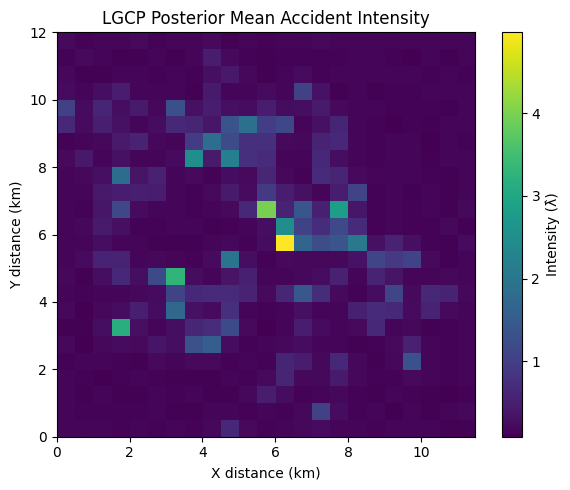

In [7]:
import matplotlib.pyplot as plt

# Get the posterior latent mean and intensity
f_post = pyro.param("f_loc").detach()                   # shape (n_cells,)
lambda_post = torch.exp(f_post).reshape(ny, nx)        # (rows=ny, cols=nx)

# Plot as a heatmap over your grid
fig, ax = plt.subplots(figsize=(6, 5))
extent = (0, nx * cell_size, 0, ny * cell_size)  # x from 0→max, y from 0→max in km
im = ax.imshow(lambda_post.numpy(), origin="lower", extent=extent, aspect="auto")
ax.set_xlabel("X distance (km)")
ax.set_ylabel("Y distance (km)")
ax.set_title("LGCP Posterior Mean Accident Intensity")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Intensity (λ̂)")
plt.tight_layout()
plt.show()


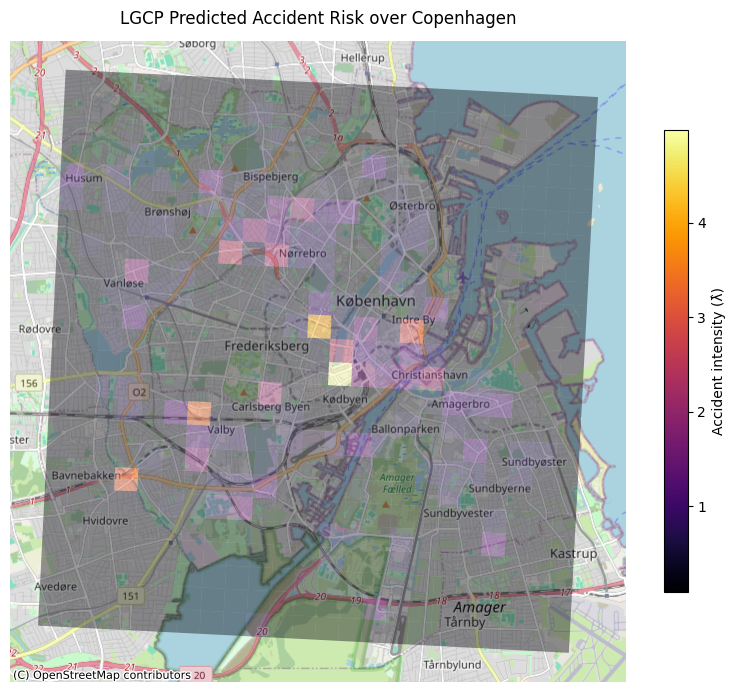

In [8]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Polygon

# Compute the original UTM shift 
coords_orig = df_day[["X","Y"]].dropna().values / 1000.0           # km
offset_km = coords_orig.min(0)                                   # (x_min, y_min) in km

# Convert each relative centroid back to absolute UTM (in metres)
# centroids was shaped (n_cells,2) in km relative to offset_km.
abs_centroids_km = centroids.numpy() + offset_km[None, :]        # km
abs_centroids_m  = abs_centroids_km * 1000                       # metres

# Build square polygons around each centroid
polys = []
intensities = []
for (x_c, y_c), lam in zip(abs_centroids_m, torch.exp(f_post).numpy()):
    half = cell_size * 500   #  cell_size/2 in km → *1000/2 in metres = *500
    # corners in metres
    poly = Polygon([
        (x_c - half, y_c - half),
        (x_c + half, y_c - half),
        (x_c + half, y_c + half),
        (x_c - half, y_c + half),
    ])
    polys.append(poly)
    intensities.append(float(lam))

gdf = gpd.GeoDataFrame(
    {"intensity": intensities},
    geometry=polys,
    crs="EPSG:25832"   # UTM zone 32N
)

# Reproject for web‐tiles
gdf_web = gdf.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(8,8))
gdf_web.plot(
    column="intensity",
    ax=ax,
    alpha=0.4,
    edgecolor="none",
    legend=True,
    cmap="inferno",
    legend_kwds={"label":"Accident intensity (λ̂)", "shrink":0.6},
)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
ax.set_title("LGCP Predicted Accident Risk over Copenhagen", pad=12)
plt.tight_layout()
plt.show()


### Continous space

Eg. not using grid but define continous space as a GP. Here is some theory

**1 Model Formulation**

We model accident locations $\{x_i\}_{i=1}^N\subset\mathcal{D}\subset\mathbb{R}^2$ as an **inhomogeneous Poisson point process** with intensity

$$
\lambda(x)\;=\;\exp\bigl(f(x)\bigr)\,,
$$

where the latent function $f:\mathcal D\to\mathbb R$ is given a **Gaussian process (GP) prior**

$$
f(\,\cdot\,)\sim\mathcal{GP}\bigl(0,\,k(\,\cdot\,,\,\cdot\,)\bigr)\,,
$$

and $k(x,x')$ is a positive-definite covariance kernel (e.g. RBF, Matérn, etc.).  The exponential ensures $\lambda(x)>0$ everywhere.


**2 Poisson-Process Likelihood**

Given $\{x_i\}$, the log-likelihood under intensity $\lambda$ is

$$
\log p\bigl(\{x_i\}\mid f\bigr)
=\sum_{i=1}^N\log\lambda(x_i)\;-\;\int_{\mathcal D}\lambda(x)\,dx
=\sum_{i=1}^N f(x_i)\;-\;\int_{\mathcal D} e^{f(x)}\,dx\,.
$$

The first term “counts” the log-intensity at observed points; the second subtracts the total mass.

**3 Monte Carlo Quadrature of the Integral**

The integral $\int_{\mathcal D}e^{f(x)}dx$ is intractable.  We approximate it by

$$
\int_{\mathcal D}e^{f(x)}dx
\;\approx\;\frac{\mathrm{Area}(\mathcal D)}{M}
\sum_{j=1}^M e^{f(u_j)}\,,
$$

where $\{u_j\}$ are $M$ points sampled uniformly in $\mathcal D$.  As $M\to\infty$ this Monte Carlo estimator is unbiased and consistent.

**4 Finite-Dimensional GP Prior**

We only ever need $f$ evaluated at the $N$ observed locations and the $M$ quadrature points.  Denote

$$
X_{\rm obs} = \{x_i\}_{i=1}^N,\quad
X_{\rm quad}=\{u_j\}_{j=1}^M,\quad
X_{\rm all}=[X_{\rm obs},X_{\rm quad}]\in\mathbb R^{(N+M)\times 2}\,.
$$

Under the GP prior,

$$
\mathbf f_{\rm all} = \bigl[f(x_1),\dots,f(x_N),\,f(u_1),\dots,f(u_M)\bigr]^\top
\sim\mathcal N\bigl(\mathbf0,\;K\bigr),
$$

where $K_{ij}=k\bigl(X_{\rm all,i},X_{\rm all,j}\bigr)$.  We add a small “jitter” or noise variance on the diagonal to ensure numerical stability in the Cholesky decomposition.

**5 Joint Log-Probability**

Combining prior and likelihood gives the complete-data log-density up to a constant:

$$
\begin{aligned}
\log p\bigl(\mathbf f_{\rm all},\{x_i\}\bigr)
&=\underbrace{-\tfrac12\,\mathbf f_{\rm all}^\top K^{-1}\,\mathbf f_{\rm all}
-\tfrac12\log|K|}_{\log p(\mathbf f_{\rm all})}
\;+\;\sum_{i=1}^N f(x_i)\;-\;\frac{\mathrm{Area}}{M}\sum_{j=1}^M e^{f(u_j)}.
\end{aligned}
$$

In Pyro we realize this by

* sampling $\mathbf f_{\rm all}\sim\mathcal N(0,K)$ via a `pyro.sample("f_all", …​)`,
* then emitting the likelihood terms as two `pyro.factor` calls inside plates of size $N$ and $M$.

**6 Variational Inference (SVI)**

Exact posterior $p(\mathbf f_{\rm all}\mid\{x_i\})$ is intractable because of the non-Gaussian Poisson likelihood.  We introduce a **variational distribution** $q(\mathbf f_{\rm all})$ (e.g. mean‐field Normal or an AutoGuide) and maximize the **Evidence Lower Bound (ELBO)**:

$$
\mathcal{L}=\mathbb{E}_{q}\Bigl[\log p(\mathbf f_{\rm all},\{x_i\}) - \log q(\mathbf f_{\rm all})\Bigr].
$$

Optimizing $\mathcal{L}$ w\.r.t.\ both guide parameters (variational means/covariances) and model parameters (kernel hyper-priors or point-estimates) gives an approximate posterior.  Pyro’s SVI machinery uses stochastic gradient ascent with Monte Carlo estimates of the ELBO gradients.

**7 Why It Works**

1. **Spatial correlation**: the GP prior $k(\cdot,\cdot)$ enforces that nearby locations have similar intensities, capturing clustering or smooth gradients in accident risk.
2. **Non-Gaussian likelihood**: the exponential link and Poisson‐process likelihood directly model the fact that accidents are discrete random events in continuous space.
3. **Tractable approximation**:

   * Monte Carlo quadrature reduces the continuous integral to a finite sum, unbiased in expectation.
   * Variational inference with SVI scales to thousands of points by trading exact posterior for a fast, vectorized optimization.
4. **Automatic differentiation**: all steps (cholesky, exponentials, sums) are differentiable, so gradients flow from the ELBO back to kernel hyper-parameters and guide parameters.


And here is the code for the above

In [9]:
import torch
import pyro
import pyro.distributions as dist
from torch.distributions import constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam
from torch.linalg import cholesky
from torch.distributions import MultivariateNormal
from pyro.infer.autoguide import AutoDiagonalNormal

# coords: your accident locations in km after centering, shape (N,2)
coords = torch.tensor(coords, dtype=torch.float32).detach().clone()  # reuse your coords array

# Define M quadrature points uniformly over the bounding box of coords
N, _ = coords.shape
M = 1000  # Numper of samples 

# Compute bounding‐box mins and ranges as tensors
x_min, y_min = coords.min(0).values          # both floats
x_max, y_max = coords.max(0).values          # both floats
mins   = torch.tensor([x_min, y_min])        # shape (2,)
ranges = torch.tensor([x_max - x_min,
                       y_max - y_min])      # shape (2,)

# Draw M uniform points in [0,1]^2, then scale & shift
U = torch.rand(M, 2) * ranges[None, :] + mins[None, :]  # shape (M,2)

# Compute domain area in km² for the bounding box
area = (x_max - x_min) * (y_max - y_min)

# Pre-stack all locations for the GP: first the observed points, then quadrature
X_all = torch.cat([coords, U], dim=0)  # shape (N+M, 2)

# RBF kernel function
def rbf_kernel(X1, X2, ls, var):
    d = torch.cdist(X1, X2)
    return var * torch.exp(-0.5 * (d/ls)**2)


def model(coords, U, area):
    """
    coords:   (N,2) tensor of observed accident locations
    U:        (M,2) tensor of quadrature locations (inside study area)
    area:     float, total area of study region
    """
    N = coords.shape[0]
    M = U.shape[0]

    # Sample kernel hyper‐parameters (priors)
    ls    = pyro.sample("lengthscale", dist.LogNormal(0., 0.5))
    var   = pyro.sample("variance",    dist.LogNormal(0., 1.0))
    noise = pyro.sample("noise",       dist.LogNormal(-3., 0.3))

    # Build full covariance over all points
    X_all = torch.cat([coords, U], dim=0)       # shape (N+M, 2)
    K = rbf_kernel(X_all, X_all, ls, var)
    K = 0.5*(K + K.T)                            # enforce symmetry
    K = K + (noise + 1e-4) * torch.eye(N+M)     # jitter + noise
    L = cholesky(K)                             # lower‐Cholesky

    # Sample the latent GP at all points
    f_all = pyro.sample(
        "f_all",
        dist.MultivariateNormal(
            loc=torch.zeros(N+M),
            scale_tril=L
        )
    )

    # Split into observed vs quadrature
    f_obs  = f_all[:N]      # latent at each accident
    f_quad = f_all[N:]      # latent at each quadrature site

    # Log‐likelihood via Monte‐Carlo quadrature 
    with pyro.plate("obs", N):
        # each observed point contributes +f(x_i) to the log‐likelihood
        pyro.factor("obs_ll", f_obs)

    with pyro.plate("quad", M):
        # each quadrature point contributes −(area/M) * exp(f(u_j))
        pyro.factor("quad_ll", - (area / M) * torch.exp(f_quad))


guide = AutoDiagonalNormal(model)

# Inference SVI
pyro.clear_param_store()
optimizer = ClippedAdam({"lr": 0.02})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

num_steps = 1000
for step in range(1, num_steps+1):
    loss = svi.step(coords, U, area)
    if step % 100 == 0:
        print(f"[{step:4d}]  ELBO = {-loss:.1f}")

[ 100]  ELBO = -193.2
[ 200]  ELBO = -179.7
[ 300]  ELBO = -174.1
[ 400]  ELBO = -172.9
[ 500]  ELBO = -159.8
[ 600]  ELBO = -174.0
[ 700]  ELBO = -157.1
[ 800]  ELBO = -156.3
[ 900]  ELBO = -148.8
[1000]  ELBO = -153.7


In [10]:
# draw samples from the variational posterior
predictive = Predictive(model, guide=guide, num_samples=1000, return_sites=["f_all"])
samples    = predictive(coords, U, area)

# samples["f_all"] has shape [200, N+M]
f_all_post = samples["f_all"].mean(0)         # Monte-Carlo posterior mean, shape (N+M,)

# slice into obs vs quad
N = coords.size(0)
f_obs_mean  = f_all_post[:N]
f_quad_mean = f_all_post[:,N:]

# compute intensities
λ_obs      = torch.exp(f_obs_mean)
lambda_quad = torch.exp(f_quad_mean).squeeze()

/tmp/ipykernel_9/1903444613.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  abs_U_km = U + offset_km                   # (M,2) in km


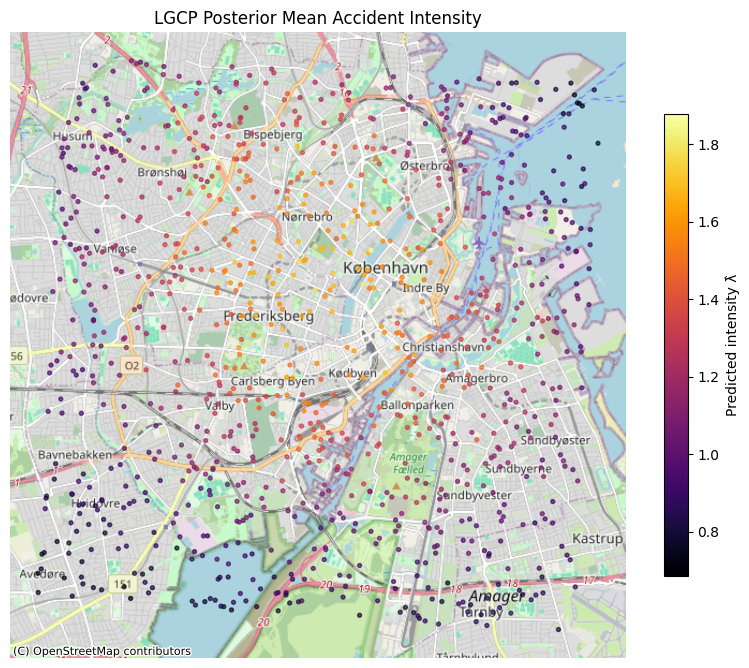

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

# Compute absolute UTM for quadrature points
abs_U_km = U + offset_km                   # (M,2) in km
abs_U_m  = abs_U_km * 1000                 # to metres

# Build GeoDataFrame
gdf = gpd.GeoDataFrame(
    {"intensity": lambda_quad.numpy()},
    geometry=[Point(x, y) for x, y in abs_U_m.numpy()],
    crs="EPSG:25832"
)

# Reproject for map tiles
gdf_web = gdf.to_crs(epsg=3857)

# Plot heatmap points over OSM basemap
fig, ax = plt.subplots(figsize=(8,8))
gdf_web.plot(
    column="intensity",
    ax=ax,
    markersize=8,
    alpha=0.7,
    cmap="inferno",
    legend=True,
    legend_kwds={"label":"Predicted intensity λ̂", "shrink":0.6}
)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
ax.set_title("LGCP Posterior Mean Accident Intensity")
plt.tight_layout()
plt.show()

### Not refined...

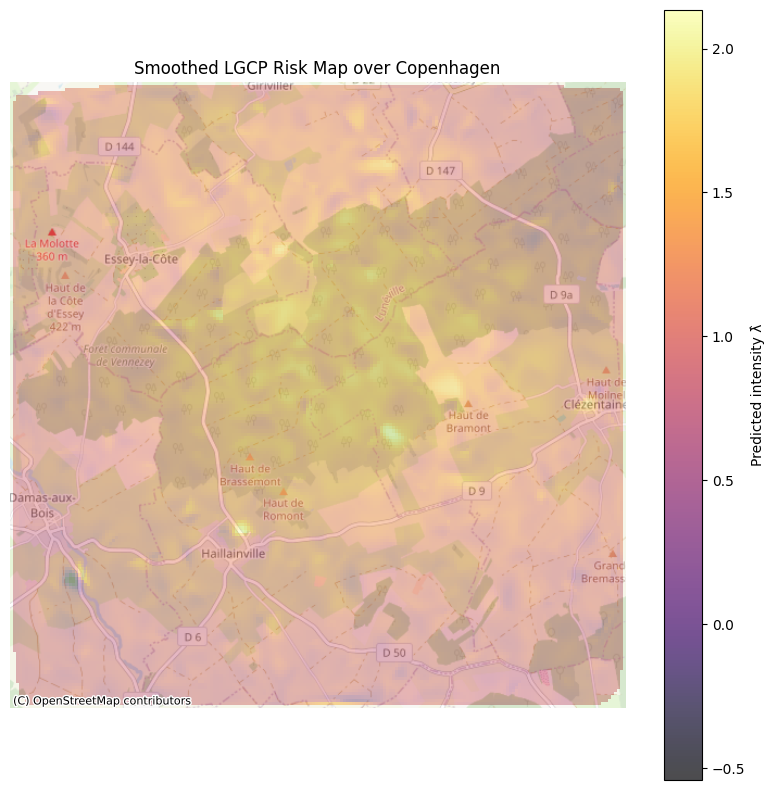

In [ ]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Polygon

# 1. Extract your quad locations (in metres) and intensities
pts = abs_U_m.numpy()              # shape (M,2), UTM metres
vals = lambda_quad.numpy()         # shape (M,)

# 2. Define a regular grid over the bounding box
x_min, y_min = pts.min(axis=0)
x_max, y_max = pts.max(axis=0)
nx, ny = 200, 200
xi = np.linspace(x_min, x_max, nx)
yi = np.linspace(y_min, y_max, ny)
Xi, Yi = np.meshgrid(xi, yi)

# 3. Interpolate
Zi = griddata(pts, vals, (Xi, Yi), method='cubic', fill_value=np.nan)

# 4. Plot as an image under a basemap
fig, ax = plt.subplots(figsize=(8,8))

# Show the interpolated heatmap (note extent in metres)
im = ax.imshow(Zi,
               origin='lower',
               extent=(x_min, x_max, y_min, y_max),
               cmap='inferno',
               alpha=0.7)
fig.colorbar(im, ax=ax, label='Predicted intensity λ̂')

gdf_web = gdf.to_crs(epsg=3857)

# Overlay OSM tiles
# Convert to EPSG:3857
# We'll need to transform the image, so a simpler workaround is:
# draw the image first, then add basemap:
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik,
                crs='EPSG:3857',
                alpha=0.5)

ax.set_axis_off()
ax.set_title("Smoothed LGCP Risk Map over Copenhagen")
plt.tight_layout()
plt.show()


In [70]:
gdf_web.total_bounds

array([1387007.58080955, 7483442.14444778, 1406978.1430829 ,
       7503600.02427656])

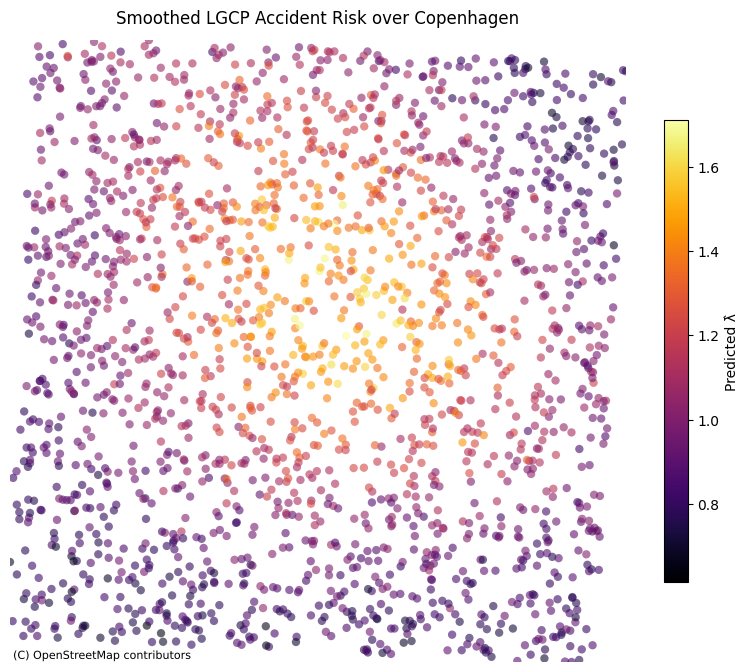

In [71]:
import matplotlib.pyplot as plt
import contextily as ctx

# 1. Get the Web-Mercator bounds of your data
xmin, ymin, xmax, ymax = gdf_web.total_bounds  # in EPSG:3857

# 2. Create the figure and add the basemap
fig, ax = plt.subplots(figsize=(8, 8))
ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    crs="EPSG:3857",
    zoom=12,                # adjust up/down for more detail
)

# 3. Plot your interpolated grid‐cells on top
gdf_web.plot(
    column="intensity",
    ax=ax,
    cmap="inferno",
    alpha=0.6,
    edgecolor="none",
    legend=True,
    legend_kwds={"label":"Predicted λ̂", "shrink":0.6},
    zorder=10              # ensure it draws above the basemap
)

# 4. Zoom to your actual data region
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# 5. Tidy up
ax.set_axis_off()
ax.set_title("Smoothed LGCP Accident Risk over Copenhagen", pad=12)
plt.tight_layout()
plt.show()
